In [1]:
import pandas as pd
#Google colab does not have pickle
try:
  import pickle5 as pickle
except:
  !pip install pickle5
  import pickle5 as pickle
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from numpy import random
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score,confusion_matrix, roc_curve, auc

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 133kB 9.7MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219255 sha256=6dfbad5909f23636a355bf0045cc27abe7c9888fba14a5c6a061554b15c7475c
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5
Mounted at /content/drive


In [2]:

def combine_AC(df,chunksize=3,seperate_chunks=False):
  if not seperate_chunks:
    df.Human = df.Human.apply(lambda x: [''.join(x)[i:i+chunksize] for i in range(0, len(''.join(x))) if len(''.join(x)[i:i+chunksize])>=chunksize])
    df.Yersinia = df.Yersinia.apply(lambda x: [''.join(x)[i:i+chunksize] for i in range(0, len(''.join(x))) if len(''.join(x)[i:i+chunksize])>=chunksize])
    df.Joined = [df.loc[row]['Human']+df.loc[row]['Yersinia'] for row in range(df.shape[0])]
    return df
  #print("JHGVBJGHGHKHGKG")
  df.Human = df.Human.apply(lambda x: [''.join(x)[i:i+chunksize] for i in range(0, len(''.join(x)), chunksize)])
  df.Yersinia = df.Yersinia.apply(lambda x: [''.join(x)[i:i+chunksize] for i in range(0, len(''.join(x)), chunksize)])
  df.Joined = [df.loc[row]['Human']+df.loc[row]['Yersinia'] for row in range(df.shape[0])]
  return df

def shuff_together(df1,df2):
    joined = pd.concat([df1,df2], axis=0)
    joined = joined.iloc[np.random.permutation(len(joined))].reset_index(drop=True)
    return joined.iloc[:df1.shape[0],:],joined.iloc[df1.shape[0]:,:].reset_index(drop=True)
def load_data(D=1,randomize=False):
    try:
        with open('/content/drive/MyDrive/ML_Data/df_train_'+str(D)+'D.pickle', 'rb') as handle:
            df_train = pickle.load(handle)
    except:
        df_train = pd.read_pickle("C:/Users/nik00/py/proj/hyppi-train.pkl")
    try:
        with open('/content/drive/MyDrive/ML_Data/df_test_'+str(D)+'D.pickle', 'rb') as handle:
            df_test = pickle.load(handle)
    except:
        df_test = pd.read_pickle("C:/Users/nik00/py/proj/hyppi-independent.pkl")
    if randomize:
        return shuff_together(df_train,df_test)
    else:
        return df_train,df_test

def get_seq_data_join(MAX_VOCAB_SIZE, MAX_SEQUENCE_LENGTH):
  print("MAX_VOCAB_SIZE is",MAX_VOCAB_SIZE)
  print("MAX_SEQUENCE_LENGTH is",MAX_SEQUENCE_LENGTH)
  sentences = pd.DataFrame(' '.join(df_train.loc[i]['Joined']) for i in range(df_train.shape[0])).values.flatten()
  tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
  tokenizer.fit_on_texts(sentences)
  sequences = tokenizer.texts_to_sequences(sentences)
  print("max sequence_data length:", max(len(s) for s in sequences))
  print("min sequence_data length:", min(len(s) for s in sequences))
  s = sorted(len(s) for s in sequences)
  print("median sequence_data length:", s[len(s) // 2])

  print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))
  word2idx = tokenizer.word_index
  print('Found %s unique tokens.' % len(word2idx))
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
  print('Shape of data tensor:', data.shape)
  sentences_test = pd.DataFrame(' '.join(df_test.loc[i]['Joined']) for i in range(df_test.shape[0])).values.flatten()
  sequences_test = tokenizer.texts_to_sequences(sentences_test)
  print("max sequences_test length:", max(len(s) for s in sequences_test))
  print("min sequences_test length:", min(len(s) for s in sequences_test))
  s = sorted(len(s) for s in sequences_test)
  print("median sequences_test length:", s[len(s) // 2])
  data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
  print('Shape of data_test tensor:', data_test.shape)
  num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
  print("num_words is",num_words)
  return data,data_test,num_words,MAX_SEQUENCE_LENGTH,MAX_VOCAB_SIZE

def embedding_layer(num_words,MAX_SEQUENCE_LENGTH,EMBEDDING_DIM):
  embedding_matrix = random.uniform(-1, 1,(num_words,EMBEDDING_DIM))
  embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=True)
  return embedding_layer

In [3]:
df_train,df_test = load_data(6)
# combine_AC(df_train,5)
# combine_AC(df_test,5)
# with open('/content/drive/MyDrive/ML_Data/df_train_6D.pickle', 'wb') as handle:
#     pickle.dump(df_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/content/drive/MyDrive/ML_Data/df_train_6D.pickle', 'rb') as handle:
#     b = pickle.load(handle)
print('The data used will be:')
df_train[['Joined']]

The data used will be:


,Joined
0,"[MKDKQK, KDKQKK, DKQKKK, KQKKKK, QKKKKE, KKKKE..."
1,"[MSWSGL, SWSGLL, WSGLLH, SGLLHG, GLLHGL, LLHGL..."
2,"[MSLFDL, SLFDLF, LFDLFR, FDLFRG, DLFRGF, LFRGF..."
3,"[MAVAPR, AVAPRL, VAPRLF, APRLFG, PRLFGG, RLFGG..."
4,"[MSTIQS, STIQSE, TIQSET, IQSETD, QSETDC, SETDC..."
...,...
6265,"[MSYFGE, SYFGEH, YFGEHF, FGEHFW, GEHFWG, EHFWG..."
6266,"[MTVGKS, TVGKSS, VGKSSK, GKSSKM, KSSKML, SSKML..."
6267,"[MNNLSF, NNLSFS, NLSFSE, LSFSEL, SFSELC, FSELC..."
6268,"[MAPEIN, APEINL, PEINLP, EINLPG, INLPGP, NLPGP..."


Median length of Joined sequence is 871


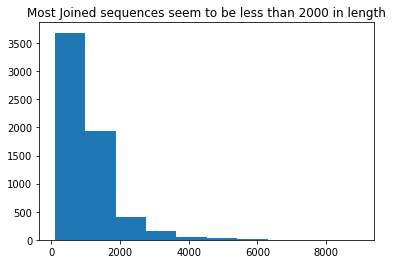

In [4]:
lengths = sorted(len(s) for s in df_train['Joined'])
print("Median length of Joined sequence is",lengths[len(lengths)//2])
_ = plt.hist(lengths)
_=plt.title("Most Joined sequences seem to be less than 2000 in length")

In [5]:
data_6D_join,data_test_6D_join,num_words_6D,MAX_SEQUENCE_LENGTH_6D,MAX_VOCAB_SIZE_6D = get_seq_data_join(MAX_SEQUENCE_LENGTH = 1000,MAX_VOCAB_SIZE = 1000000)

MAX_VOCAB_SIZE is 1000000
MAX_SEQUENCE_LENGTH is 1000
max sequence_data length: 6856
min sequence_data length: 5
median sequence_data length: 477
max word index: 999999
Found 3205693 unique tokens.
Shape of data tensor: (6270, 1000)
max sequences_test length: 5558
min sequences_test length: 4
median sequences_test length: 301
Shape of data_test tensor: (1514, 1000)
num_words is 1000000


In [6]:
embedding_layer_6D_join = embedding_layer(num_words_6D,MAX_SEQUENCE_LENGTH_6D,EMBEDDING_DIM = 400)
BATCH_SIZE = 128
EPOCHS = 20
M_6D=100

In [7]:

print('Building model...')

ip = Input(shape=(MAX_SEQUENCE_LENGTH_6D,),name = 'model6D_join_ip')
x = embedding_layer_6D_join(ip)
x = Bidirectional(LSTM(M_6D, return_sequences=True),name = 'model6D_join_Bidirectional')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation="sigmoid")(x)
model6D_join = Model(ip, output)

model6D_join.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)


print('Training model...')
jk = model6D_join.fit(
  data_6D_join,
  df_train['label'].values,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  #validation_split=VALIDATION_SPLIT
)


Building model...
Training model...
Epoch 1/20
49/49 [==============================] - 152s 3s/step - loss: 0.8391 - accuracy: 0.6599
Epoch 2/20
49/49 [==============================] - 121s 2s/step - loss: 0.2562 - accuracy: 0.9038
Epoch 3/20
49/49 [==============================] - 119s 2s/step - loss: 0.1065 - accuracy: 0.9635
Epoch 4/20
49/49 [==============================] - 137s 3s/step - loss: 0.0578 - accuracy: 0.9822
Epoch 5/20
49/49 [==============================] - 126s 3s/step - loss: 0.0364 - accuracy: 0.9848
Epoch 6/20
49/49 [==============================] - 122s 2s/step - loss: 0.0255 - accuracy: 0.9911
Epoch 7/20
49/49 [==============================] - 109s 2s/step - loss: 0.0238 - accuracy: 0.9903
Epoch 8/20
49/49 [==============================] - 126s 3s/step - loss: 0.0173 - accuracy: 0.9931
Epoch 9/20
49/49 [==============================] - 105s 2s/step - loss: 0.0156 - accuracy: 0.9920
Epoch 10/20
49/49 [==============================] - 106s 2s/step - loss:

In [8]:
yhat =  model6D_join.predict(data_test_6D_join)
y = df_test['label'].values
fpr, tpr, thresholds = roc_curve(y, yhat)
auc = auc(fpr, tpr)
auc

0.8497161673783569

In [10]:
#model6D_join.save('/content/drive/MyDrive/ML_Data/model6D_join.h5')